In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from skorch.regressor import NeuralNetRegressor
from tabularasa.MixedMonotonicNet import MixedMonotonicNet
from tabularasa.OrthonormalCertificatesRegressor import OrthonormalCertificatesNet, OrthonormalCertificatesRegressor

In [2]:
df = pd.read_pickle('./examples/data/simple_train.pkl')

In [3]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb1 = nn.Embedding(50, 16)
        self.fc1 = nn.Linear(1 + 16, 16)
    
    def forward(self, X_non_monotonic):
        X = torch.cat([X_non_monotonic[:, 1, None].float(), 
                       self.emb1(X_non_monotonic[:, 0, None].long()).squeeze()], 1)
        return F.relu(self.fc1(X))

In [4]:
model = NeuralNetRegressor(MixedMonotonicNet,
                           max_epochs=25,
                           lr=0.001,
                           optimizer=torch.optim.Adam,
                           iterator_train__shuffle=True,
                           module__non_monotonic_net=EmbeddingNet(),
                           module__dim_non_monotonic=16,
                           module__dim_monotonic=2,
                           module__layers=[128, 128, 32],
                           module__integration_steps=300)

In [5]:
model.fit({'X_monotonic': df[['x1', 'x2']].values,
           'X_non_monotonic': df[['x3', 'x4']].values},
          df[['y']].values)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.3042        0.2894  6.9626
      2        0.2894        0.2844  7.5822


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MixedMonotonicNet(
    (non_monotonic_net): EmbeddingNet(
      (emb1): Embedding(50, 16)
      (fc1): Linear(in_features=17, out_features=16, bias=True)
    )
    (umnn): SlowDMonotonicNN(
      (outer_net): MonotonicNN(
        (integrand): IntegrandNN(
          (inner_net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
            (5): ReLU()
          )
          (net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
            (5): ReLU()
            (6): Linear(in_features=32

In [6]:
quantiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

In [7]:
results = []
for q in np.quantile(df['x1'], quantiles):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = model.predict({'X_monotonic': dfc[['x1', 'x2']].values,
                       'X_non_monotonic': dfc[['x3', 'x4']].values})
    p = pd.DataFrame(pd.Series(p[:, 0]).describe(percentiles=quantiles)).T
    p['x1'] = q
    results.append(p)
results = pd.concat(results, axis=0)

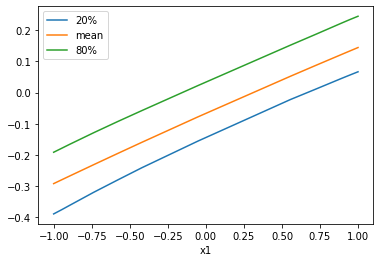

In [8]:
results.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

### Estimate epistemic uncertainty via orthonormal certificates

Start by prepping data from the inner hidden layer.

In [9]:
model.module_.set_last_layer(inner=True)

In [10]:
X_inner = model.predict({'X_monotonic': df[['x1', 'x2']].values,
                         'X_non_monotonic': df[['x3', 'x4']].values})

In [11]:
ocr = OrthonormalCertificatesRegressor(OrthonormalCertificatesNet,
                                       max_epochs=500,
                                       lr=0.01,
                                       optimizer=torch.optim.Adam,
                                       iterator_train__shuffle=True,
                                       module__dim_input=3 + 32)

In [12]:
ocr.fit(np.concatenate([df[['x1', 'x2', 'x4']].values, X_inner], axis=1))

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1257        0.0504  0.0349
      2        0.0412        0.0272  0.0462
      3        0.0215        0.0191  0.0446
      4        0.0161        0.0132  0.0434
      5        0.0131        0.0119  0.0441
      6        0.0117        0.0114  0.0448
      7        0.0112        0.0108  0.0460
      8        0.0109        0.0106  0.0429
      9        0.0107        0.0105  0.0451
     10        0.0105        0.0104  0.0447
     11        0.0104        0.0102  0.0477
     12        0.0103        0.0101  0.0481
     13        0.0102        0.0101  0.0480
     14        0.0101        0.0100  0.0469
     15        0.0100        0.0099  0.0561
     16        0.0099        0.0098  0.0609
     17        0.0098        0.0097  0.0668
     18        0.0097        0.0096  0.0633
     19        0.0096        0.0095  0.0703
     20        0.0095        0.0095  0.0577
     21        0.0095        0.0

    162        0.0085        0.0086  0.0420
    163        0.0085        0.0085  0.0426
    164        0.0084        0.0085  0.0438
    165        0.0084        0.0085  0.0525
    166        0.0084        0.0085  0.0469
    167        0.0085        0.0085  0.0565
    168        0.0085        0.0085  0.0546
    169        0.0084        0.0085  0.0469
    170        0.0084        0.0085  0.0414
    171        0.0084        0.0085  0.0431
    172        0.0084        0.0085  0.0598
    173        0.0084        0.0085  0.0535
    174        0.0084        0.0086  0.0621
    175        0.0085        0.0085  0.0585
    176        0.0084        0.0086  0.0455
    177        0.0084        0.0084  0.0411
    178        0.0084        0.0084  0.0416
    179        0.0084        0.0085  0.0451
    180        0.0085        0.0085  0.0434
    181        0.0085        0.0085  0.0454
    182        0.0085        0.0085  0.0485
    183        0.0084        0.0085  0.0584
    184        0.0084        0.0

<class 'tabularasa.OrthonormalCertificatesRegressor.OrthonormalCertificatesRegressor'>[initialized](
  module_=OrthonormalCertificatesNet(
    (certificates): Linear(in_features=35, out_features=64, bias=True)
  ),
)

Create another PDP like dataset with the full range.

In [13]:
uncertainties = []
for q in np.linspace(-1.5, 1.5, 101):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = ocr.predict(np.concatenate([dfc[['x1', 'x2', 'x4']],
                                     model.predict({'X_monotonic': dfc[['x1', 'x2']].values,
                                                    'X_non_monotonic': dfc[['x3', 'x4']].values})], axis=1))
    p = pd.DataFrame(pd.Series(p).describe(percentiles=quantiles)).T
    p['x1'] = q
    uncertainties.append(p)
uncertainties = pd.concat(uncertainties, axis=0)

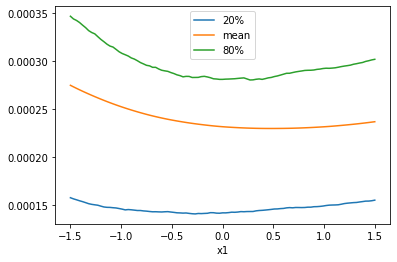

In [14]:
uncertainties.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

Epistemic uncertainty is high below -1 (where training data starts and is relatively low), decreases between -1 and 0, picks back up between 0 and 0.5, and then decreases between 0.5 and 1.  After 1, it doesn't perform exactly as desired, but is ticking up in some places.

In [15]:
p = ocr.percentile_predict(np.concatenate([df[['x1', 'x2', 'x4']],
                                     model.predict({'X_monotonic': df[['x1', 'x2']].values,
                                                    'X_non_monotonic': df[['x3', 'x4']].values})], axis=1))

In [18]:
p

array([97, 95, 95, ..., 94, 80, 72])

In [19]:
ocr.predict(np.concatenate([df[['x1', 'x2', 'x4']],
                                     model.predict({'X_monotonic': df[['x1', 'x2']].values,
                                                    'X_non_monotonic': df[['x3', 'x4']].values})], axis=1))

array([0.00027909, 0.00023174, 0.00024525, ..., 0.00020101, 0.00018255,
       0.00016368], dtype=float32)